In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D, Conv3D
from tensorflow.keras.layers import MaxPooling2D, MaxPooling3D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from sklearn.metrics import f1_score
#from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image 
import seaborn as sns
import os
import re
import glob
import cv2
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn import preprocessing
import tqdm
from numpy import loadtxt
from sklearn.utils import class_weight

Using TensorFlow backend.


In [2]:
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [atoi(c) for c in re.split('(\d+)', text)]

In [3]:
def draw_confusion_matrix(true,preds):
    conf_matx = confusion_matrix(true, preds)
    sns.heatmap(conf_matx, annot=True,annot_kws={"size": 12},fmt='g', cbar=False, cmap=plt.cm.Blues) #'viridis'
    #plt.savefig('/home/jovyan/img1.png')
    plt.show()
    
    return conf_matx

In [4]:
def plot_history(model_history, model_name):
    fig = plt.figure(figsize=(15,5), facecolor='w')
    ax = fig.add_subplot(121)
    ax.plot(model_history.history['loss'])
    ax.plot(model_history.history['val_loss'])
    ax.set(title=model_name + ': Model loss', ylabel='Loss', xlabel='Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    ax = fig.add_subplot(122)
    ax.plot(model_history.history['accuracy'])
    ax.plot(model_history.history['val_accuracy'])
    ax.set(title=model_name + ': Model Accuracy; test='+ str(np.round(model_history.history['val_accuracy'][-1], 3)),
           ylabel='Accuracy', xlabel='Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    #plt.savefig('/home/jovyan/img2.png')
    plt.show()
   
    
    return fig

In [5]:
def loadImages(path_data, path_labels):

    image_list = []
    

    for filename in sorted(glob.glob(path_data), key=natural_keys): 
        im=cv2.imread(filename)
        #gray_image = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        imarray = np.array(im)
        imarray = imarray.astype('float32')
        image_list.append(imarray)

    x_orig = np.reshape(image_list, (len(image_list), 90, 90, 3))
    
    path = path_labels    
    labels = pd.read_csv(path, usecols=["Type", "Category"],
                       sep="," )
    y_orig = np.array(labels['Category'])

    return x_orig, y_orig

In [6]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=3)

In [29]:
train_data = '/home/jovyan/DATA_MASTER_PROJECT/FINAL_Data/2_classes_no_controll/croppped_train/*.tiff'
train_lab='/home/jovyan/DATA_MASTER_PROJECT/FINAL_Data/2_classes_no_controll/train_labels.csv'


test_data='/home/jovyan/DATA_MASTER_PROJECT/FINAL_Data/2_classes_no_controll/croppped_test/*.tiff'
test_lab='/home/jovyan/DATA_MASTER_PROJECT/FINAL_Data/2_classes_no_controll/test_labels.csv'

# Train and validation set 

In [30]:
x_orig_1, y_orig_1 = tqdm.tqdm(loadImages(train_data, train_lab))
x_orig_1.shape, y_orig_1.shape

100%|██████████| 2/2 [00:00<00:00, 5127.51it/s]


((37352, 90, 90, 3), (37352,))

In [31]:
x_orig_1 = x_orig_1/255


In [32]:
x_train_1, x_val, y_train_1, y_val = train_test_split(x_orig_1, y_orig_1, test_size=0.2, random_state=999 )
x_train_1.shape, x_val.shape, y_train_1.shape, y_val.shape

((29881, 90, 90, 3), (7471, 90, 90, 3), (29881,), (7471,))

# Test set

In [33]:
x_test, y_test = loadImages(test_data, test_lab)
x_test.shape, y_test.shape

((14198, 90, 90, 3), (14198,))

In [34]:
x_test = x_test/255

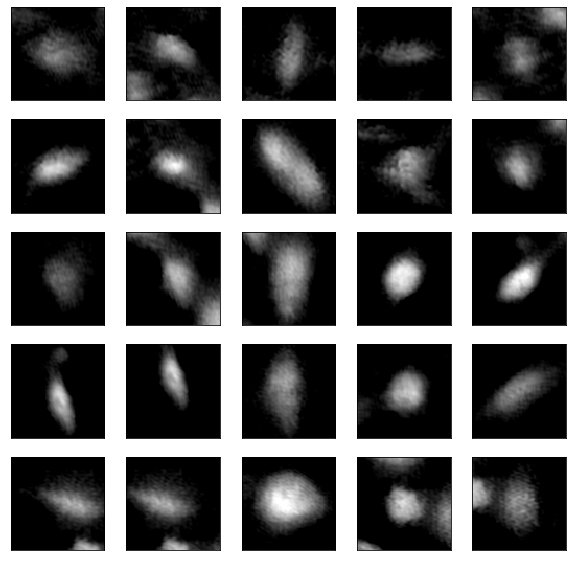

In [35]:
#Show n rabdom images to check for quality

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i], cmap=plt.cm.binary)
    #plt.xlabel(class_names[y_orig_1[i]])
plt.show()

In [36]:
unique, counts = np.unique(y_train_1, return_counts=True)
dict(zip(unique, counts))

{0: 15549, 1: 14332}

In [37]:
unique, counts = np.unique(y_val, return_counts=True)
dict(zip(unique, counts))

{0: 3835, 1: 3636}

In [38]:
weights = class_weight.compute_class_weight('balanced', np.unique(y_train_1),y_train_1)
print('weights = ' + str(weights))

weights = [0.96086565 1.04245744]


In [39]:
y_train_1 = keras.utils.to_categorical(y_train_1)
y_test_1 = keras.utils.to_categorical(y_test)
y_val = keras.utils.to_categorical(y_val)

y_train_1.shape, y_test_1.shape, y_val.shape

((29881, 2), (14198, 2), (7471, 2))

In [40]:
batch_size = 128

In [41]:
datagen = ImageDataGenerator()

datagen.fit(x_train_1)

train_gen = datagen.flow(x_train_1, y_train_1, batch_size=batch_size)

In [42]:
dat_val = ImageDataGenerator()

dat_val.fit(x_val)

val_gen = dat_val.flow(x_val, y_val, batch_size=batch_size)

In [43]:
input_shape = (90,90,3)

In [49]:
m = Sequential()
m.add(Conv2D(filters=8, kernel_size=3, strides=1, padding='same', activation='relu', input_shape = input_shape))
m.add(MaxPooling2D())

m.add(Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu'))
m.add(MaxPooling2D())

m.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
m.add(MaxPooling2D())

m.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
m.add(MaxPooling2D())

m.add(Flatten())

m.add(Dense(128, activation='relu'))

m.add(BatchNormalization())

m.add(Activation(activation='relu'))

m.add(Dense(2,activation='softmax'))
m.summary()



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 90, 90, 8)         224       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 45, 45, 8)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 45, 45, 16)        1168      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 22, 22, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 22, 22, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 11, 11, 64)       

In [50]:
opt = keras.optimizers.Adam(lr=1e-3)

m.compile(loss= keras.losses.binary_crossentropy, optimizer=opt, metrics = ['accuracy'])


In [51]:

epochs = 100

m_h = m.fit(train_gen,
                steps_per_epoch=(len(x_train_1)/batch_size),
                callbacks = [es],
                epochs=epochs,
                validation_data = val_gen, 
                validation_steps = (len(x_val)/batch_size),
                class_weight = weights)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 233.4453125 steps, validate for 58.3671875 steps
Epoch 1/100
234/233 [==============================] - 5s 23ms/step - loss: 0.6813 - accuracy: 0.5472 - val_loss: 0.7066 - val_accuracy: 0.4869
Epoch 2/100
234/233 [==============================] - 4s 19ms/step - loss: 0.6601 - accuracy: 0.5936 - val_loss: 0.7540 - val_accuracy: 0.5292
Epoch 3/100
234/233 [==============================] - 4s 18ms/step - loss: 0.6306 - accuracy: 0.6422 - val_loss: 0.7864 - val_accuracy: 0.5560
Epoch 4/100
234/233 [==============================] - 4s 18ms/step - loss: 0.5949 - accuracy: 0.6780 - val_loss: 0.8013 - val_accuracy: 0.5692
Epoch 00004: early stopping


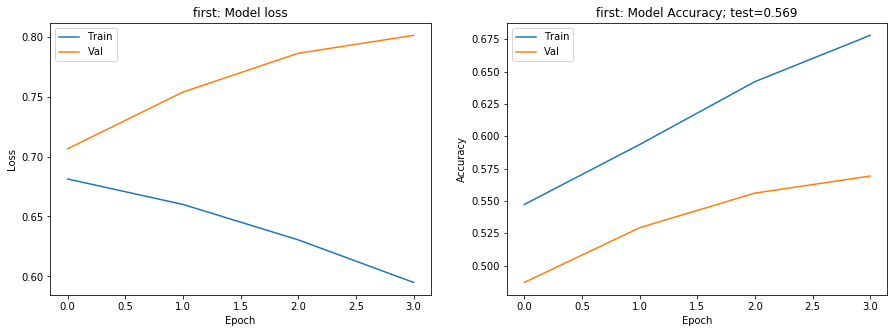

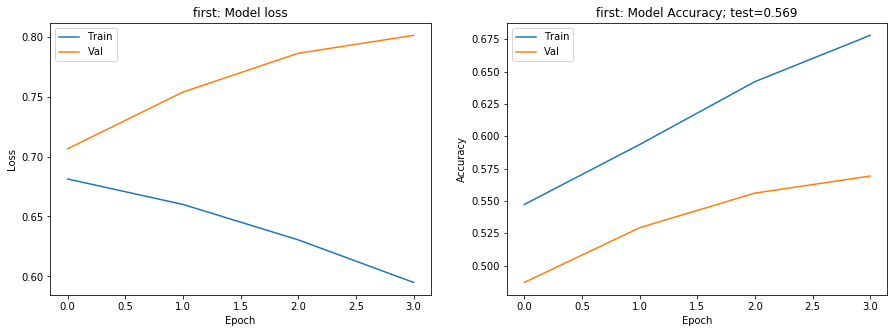

In [52]:
plot_history(m_h, 'first')


In [53]:
scores = m.evaluate(x_test, y_test_1)
print("\n%s: %.2f%%" % (m.metrics_names[1], scores[1]*100))

14198/14198 [==============================] - 2s 126us/sample - loss: 0.9496 - accuracy: 0.5063

accuracy: 50.63%


In [54]:
test_preds = m.predict(x_test)

In [55]:
preds_df = pd.DataFrame(test_preds)
predicted_labels = preds_df.idxmax(axis=1)

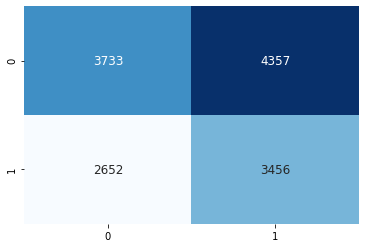

array([[3733, 4357],
       [2652, 3456]])

In [56]:
draw_confusion_matrix(y_test, predicted_labels)

In [57]:
print(classification_report(y_test, predicted_labels))

              precision    recall  f1-score   support

           0       0.58      0.46      0.52      8090
           1       0.44      0.57      0.50      6108

    accuracy                           0.51     14198
   macro avg       0.51      0.51      0.51     14198
weighted avg       0.52      0.51      0.51     14198



In [ ]:
#p = '/home/jovyan/Saved_Models/'
#m.save(p + "CNN_A59_modell.h5")